In [ ]:
import numpy as np
import os

from type_definitions.test_case import TestCase
from type_definitions.test_result import TestResult
from type_definitions.utils import *
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
seed = 100
save_plot = False
use_cached_distance_matrix = True  # Set to False to force recalculation

In [3]:
np.random.seed(seed)

cases = generate_cases(300)
results = evaluate_cases(cases)
trajectories = [r.trajectory for r in results if not r.simulation_failed]
valid_results = [r for r in results if not r.simulation_failed]
print(f"Generated {len(trajectories)} valid trajectories")
print(
    f"Crashed: {sum(1 for r in valid_results if r.crashed)}, Safe: {sum(1 for r in valid_results if not r.crashed)}"
)

Generated 114 valid trajectories
Crashed: 82, Safe: 32


In [4]:
os.makedirs("cache", exist_ok=True)
distance_matrix_file = (
    f"cache/altitude_distance_matrix_seed{seed}_size{len(trajectories)}.npy"
)

if use_cached_distance_matrix and os.path.exists(distance_matrix_file):
    print(f"Loading altitude-based distance matrix from {distance_matrix_file}")
    distance_matrix = np.load(distance_matrix_file)
else:
    print("Calculating pairwise altitude distances...")
    distance_matrix = pairwise_altitude_distances(trajectories)
    np.save(distance_matrix_file, distance_matrix)
    print(f"Altitude distance matrix saved to {distance_matrix_file}")

print(f"Distance matrix shape: {distance_matrix.shape}")

# OPTICS clustering based on altitude trajectories
optics = OPTICS(min_samples=3, metric="precomputed", cluster_method="xi", xi=0.05)
clusters = optics.fit_predict(distance_matrix)
unique_clusters = np.unique(clusters)
reachability = optics.reachability_
ordering = optics.ordering_

# Calculate cluster statistics
print("Cluster statistics:")
for cluster_id in unique_clusters:
    if cluster_id == -1:  # Skip noise points
        continue
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = len(cluster_results)
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    print(
        f"    Cluster {cluster_id}: {crashed_in_cluster}/{total_in_cluster} crashed ({crash_rate:.2f}%)"
    )

Calculating pairwise altitude distances...
Altitude distance matrix saved to cache/altitude_distance_matrix_seed100_size114.npy
Distance matrix shape: (114, 114)
Cluster statistics:
    Cluster 0: 0/3 crashed (0.00%)
    Cluster 1: 0/5 crashed (0.00%)
    Cluster 2: 6/6 crashed (100.00%)
    Cluster 3: 4/4 crashed (100.00%)
    Cluster 4: 3/3 crashed (100.00%)
    Cluster 5: 6/6 crashed (100.00%)
    Cluster 6: 4/4 crashed (100.00%)
    Cluster 7: 8/8 crashed (100.00%)
    Cluster 8: 4/4 crashed (100.00%)
    Cluster 9: 3/3 crashed (100.00%)
    Cluster 10: 7/7 crashed (100.00%)
    Cluster 11: 1/8 crashed (12.50%)
    Cluster 12: 8/8 crashed (100.00%)


In [5]:
# Calculate coverage metrics
total_test_cases = len(valid_results)
noise_points = np.sum(clusters == -1)
cluster_ids = unique_clusters[unique_clusters != -1]  # Exclude noise
num_clusters = len(cluster_ids)

# Calculate cluster sizes and proportions
cluster_sizes = {}
cluster_proportions = {}
cluster_coverage_percentages = {}

for cluster_id in cluster_ids:
    cluster_mask = clusters == cluster_id
    size = np.sum(cluster_mask)
    cluster_sizes[cluster_id] = size
    cluster_proportions[cluster_id] = (
        size / total_test_cases if total_test_cases > 0 else 0
    )
    cluster_coverage_percentages[cluster_id] = cluster_proportions[cluster_id] * 100

# Store coverage metrics
coverage_metrics = {
    "total_test_cases": total_test_cases,
    "num_clusters": num_clusters,
    "noise_points": noise_points,
    "noise_percentage": (
        (noise_points / total_test_cases * 100) if total_test_cases > 0 else 0
    ),
    "cluster_sizes": cluster_sizes,
    "cluster_proportions": cluster_proportions,
    "cluster_coverage_percentages": cluster_coverage_percentages,
}

In [6]:
# Print coverage metrics summary
print("=" * 60)
print("OPTICS ALTITUDE-BASED CLUSTERING COVERAGE METRICS SUMMARY")
print("=" * 60)
print(f"\nTotal Test Cases: {coverage_metrics['total_test_cases']}")
print(f"Number of Clusters: {coverage_metrics['num_clusters']}")
print(
    f"Noise Points: {coverage_metrics['noise_points']} ({coverage_metrics['noise_percentage']:.2f}%)"
)
print(f"\nCluster Distribution:")
print("-" * 60)

# Sort clusters by size (descending)
sorted_clusters = sorted(cluster_ids, key=lambda x: cluster_sizes[x], reverse=True)

for cluster_id in sorted_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = cluster_sizes[cluster_id]
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    coverage_pct = cluster_coverage_percentages[cluster_id]

    print(
        f"Cluster {cluster_id:2d}: Size={total_in_cluster:3d} ({coverage_pct:5.2f}% coverage) | "
        f"Crashed={crashed_in_cluster:3d}/{total_in_cluster:3d} ({crash_rate:5.2f}%)"
    )

print("-" * 60)

# Calculate cluster size statistics
if len(cluster_sizes) > 0:
    sizes_list = list(cluster_sizes.values())
    print(f"\nCluster Size Statistics:")
    print(f"  Min: {min(sizes_list)}")
    print(f"  Max: {max(sizes_list)}")
    print(f"  Mean: {np.mean(sizes_list):.2f}")
    print(f"  Median: {np.median(sizes_list):.2f}")
    print(f"  Std Dev: {np.std(sizes_list):.2f}")

# Coverage distribution analysis
coverage_values = list(cluster_coverage_percentages.values())
if len(coverage_values) > 0:
    print(f"\nCoverage Distribution:")
    print(f"  Min Coverage: {min(coverage_values):.2f}%")
    print(f"  Max Coverage: {max(coverage_values):.2f}%")
    print(f"  Mean Coverage: {np.mean(coverage_values):.2f}%")
    print(
        f"  Coverage Balance Score: {1 - np.std(coverage_values) / np.mean(coverage_values):.3f} "
        + f"(1.0 = perfectly balanced, lower = more skewed)"
    )

print("=" * 60)
print("=" * 60)
print(f"\nTotal Test Cases: {coverage_metrics['total_test_cases']}")
print(f"Number of Clusters: {coverage_metrics['num_clusters']}")
print(
    f"Noise Points: {coverage_metrics['noise_points']} ({coverage_metrics['noise_percentage']:.2f}%)"
)
print(f"\nCluster Distribution:")
print("-" * 60)

# Sort clusters by size (descending)
sorted_clusters = sorted(cluster_ids, key=lambda x: cluster_sizes[x], reverse=True)

for cluster_id in sorted_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = cluster_sizes[cluster_id]
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    coverage_pct = cluster_coverage_percentages[cluster_id]

    print(
        f"Cluster {cluster_id:2d}: Size={total_in_cluster:3d} ({coverage_pct:5.2f}% coverage) | "
        f"Crashed={crashed_in_cluster:3d}/{total_in_cluster:3d} ({crash_rate:5.2f}%)"
    )

print("-" * 60)

# Calculate cluster size statistics
if len(cluster_sizes) > 0:
    sizes_list = list(cluster_sizes.values())
    print(f"\nCluster Size Statistics:")
    print(f"  Min: {min(sizes_list)}")
    print(f"  Max: {max(sizes_list)}")
    print(f"  Mean: {np.mean(sizes_list):.2f}")
    print(f"  Median: {np.median(sizes_list):.2f}")
    print(f"  Std Dev: {np.std(sizes_list):.2f}")

# Coverage distribution analysis
coverage_values = list(cluster_coverage_percentages.values())
if len(coverage_values) > 0:
    print(f"\nCoverage Distribution:")
    print(f"  Min Coverage: {min(coverage_values):.2f}%")
    print(f"  Max Coverage: {max(coverage_values):.2f}%")
    print(f"  Mean Coverage: {np.mean(coverage_values):.2f}%")
    print(
        f"  Coverage Balance Score: {1 - np.std(coverage_values) / np.mean(coverage_values):.3f} "
        + f"(1.0 = perfectly balanced, lower = more skewed)"
    )

print("=" * 60)
print(f"\nTotal Test Cases: {coverage_metrics['total_test_cases']}")
print(f"Number of Clusters: {coverage_metrics['num_clusters']}")
print(
    f"Noise Points: {coverage_metrics['noise_points']} ({coverage_metrics['noise_percentage']:.2f}%)"
)
print(f"\nCluster Distribution:")
print("-" * 60)

# Sort clusters by size (descending)
sorted_clusters = sorted(cluster_ids, key=lambda x: cluster_sizes[x], reverse=True)

for cluster_id in sorted_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = cluster_sizes[cluster_id]
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    coverage_pct = cluster_coverage_percentages[cluster_id]

    print(
        f"Cluster {cluster_id:2d}: Size={total_in_cluster:3d} ({coverage_pct:5.2f}% coverage) | "
        f"Crashed={crashed_in_cluster:3d}/{total_in_cluster:3d} ({crash_rate:5.2f}%)"
    )

print("-" * 60)

# Calculate cluster size statistics
if len(cluster_sizes) > 0:
    sizes_list = list(cluster_sizes.values())
    print(f"\nCluster Size Statistics:")
    print(f"  Min: {min(sizes_list)}")
    print(f"  Max: {max(sizes_list)}")
    print(f"  Mean: {np.mean(sizes_list):.2f}")
    print(f"  Median: {np.median(sizes_list):.2f}")
    print(f"  Std Dev: {np.std(sizes_list):.2f}")

# Coverage distribution analysis
coverage_values = list(cluster_coverage_percentages.values())
if len(coverage_values) > 0:
    print(f"\nCoverage Distribution:")
    print(f"  Min Coverage: {min(coverage_values):.2f}%")
    print(f"  Max Coverage: {max(coverage_values):.2f}%")
    print(f"  Mean Coverage: {np.mean(coverage_values):.2f}%")
    print(
        f"  Coverage Balance Score: {1 - np.std(coverage_values) / np.mean(coverage_values):.3f} "
        + f"(1.0 = perfectly balanced, lower = more skewed)"
    )

print("=" * 60)

OPTICS ALTITUDE-BASED CLUSTERING COVERAGE METRICS SUMMARY

Total Test Cases: 114
Number of Clusters: 13
Noise Points: 45 (39.47%)

Cluster Distribution:
------------------------------------------------------------
Cluster  7: Size=  8 ( 7.02% coverage) | Crashed=  8/  8 (100.00%)
Cluster 11: Size=  8 ( 7.02% coverage) | Crashed=  1/  8 (12.50%)
Cluster 12: Size=  8 ( 7.02% coverage) | Crashed=  8/  8 (100.00%)
Cluster 10: Size=  7 ( 6.14% coverage) | Crashed=  7/  7 (100.00%)
Cluster  2: Size=  6 ( 5.26% coverage) | Crashed=  6/  6 (100.00%)
Cluster  5: Size=  6 ( 5.26% coverage) | Crashed=  6/  6 (100.00%)
Cluster  1: Size=  5 ( 4.39% coverage) | Crashed=  0/  5 ( 0.00%)
Cluster  3: Size=  4 ( 3.51% coverage) | Crashed=  4/  4 (100.00%)
Cluster  6: Size=  4 ( 3.51% coverage) | Crashed=  4/  4 (100.00%)
Cluster  8: Size=  4 ( 3.51% coverage) | Crashed=  4/  4 (100.00%)
Cluster  0: Size=  3 ( 2.63% coverage) | Crashed=  0/  3 ( 0.00%)
Cluster  4: Size=  3 ( 2.63% coverage) | Crashed=  3

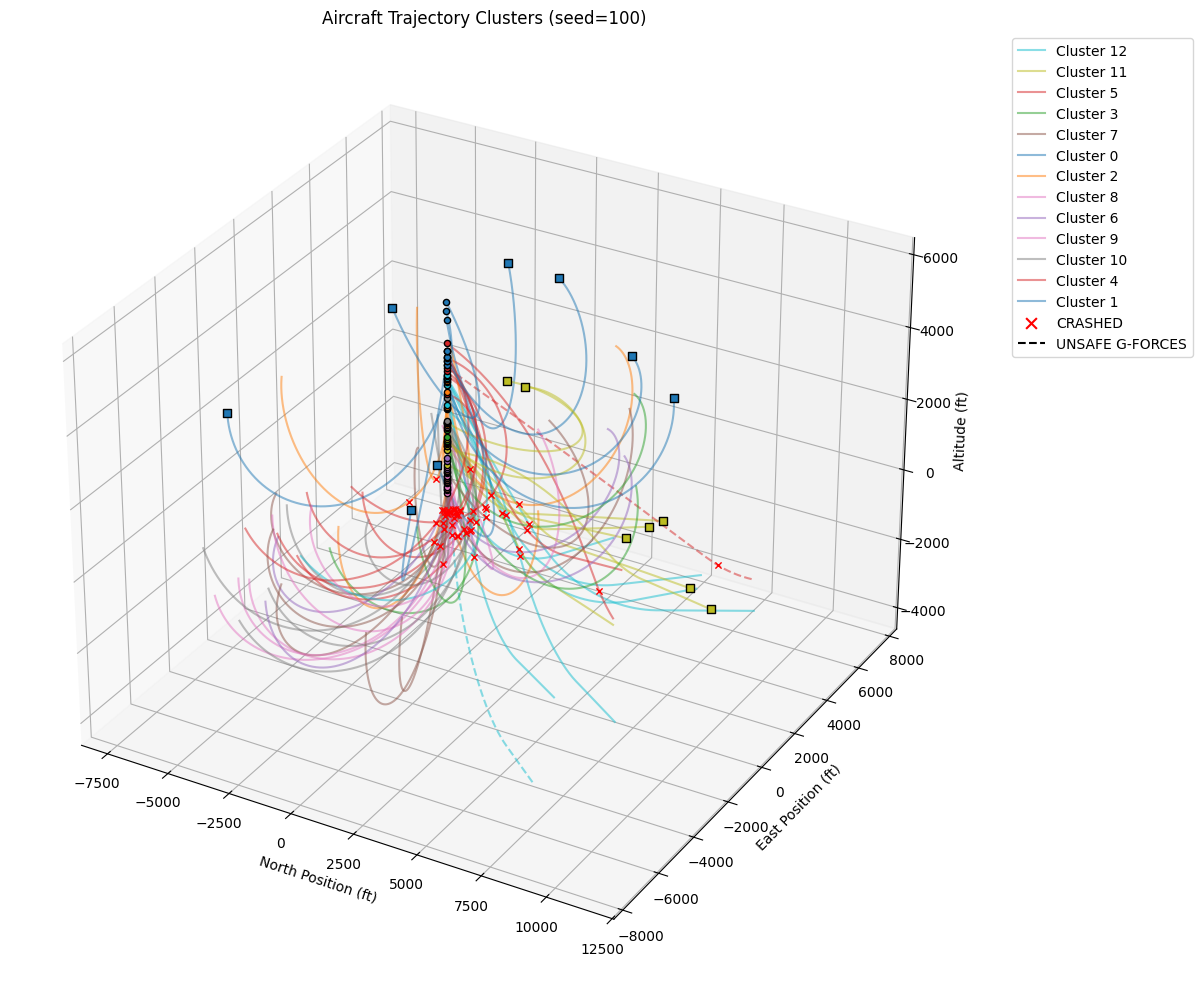

In [7]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

valid_results = [r for r in results if not r.simulation_failed]

plotted_clusters = set()

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]
    if cluster_id not in plotted_clusters:
        label = f"Cluster {cluster_id}"
        plotted_clusters.add(cluster_id)
    else:
        label = None

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=0.5,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    # end points
    if result.crashed:
        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]
            crash_z = traj[min_alt_idx, 2]

        ax.scatter(
            crash_x,
            crash_y,
            crash_z,
            color="red",
            s=20,
            marker="x",
            linewidth=1,
        )
    else:
        ax.scatter(
            traj[-1, 0],
            traj[-1, 1],
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

# Add legend for unsafe g-forces
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title(f"Aircraft Trajectory Clusters (seed={seed})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_3d.png")
    print(f"Plot saved to results/{seed}_clusters_3d.png")

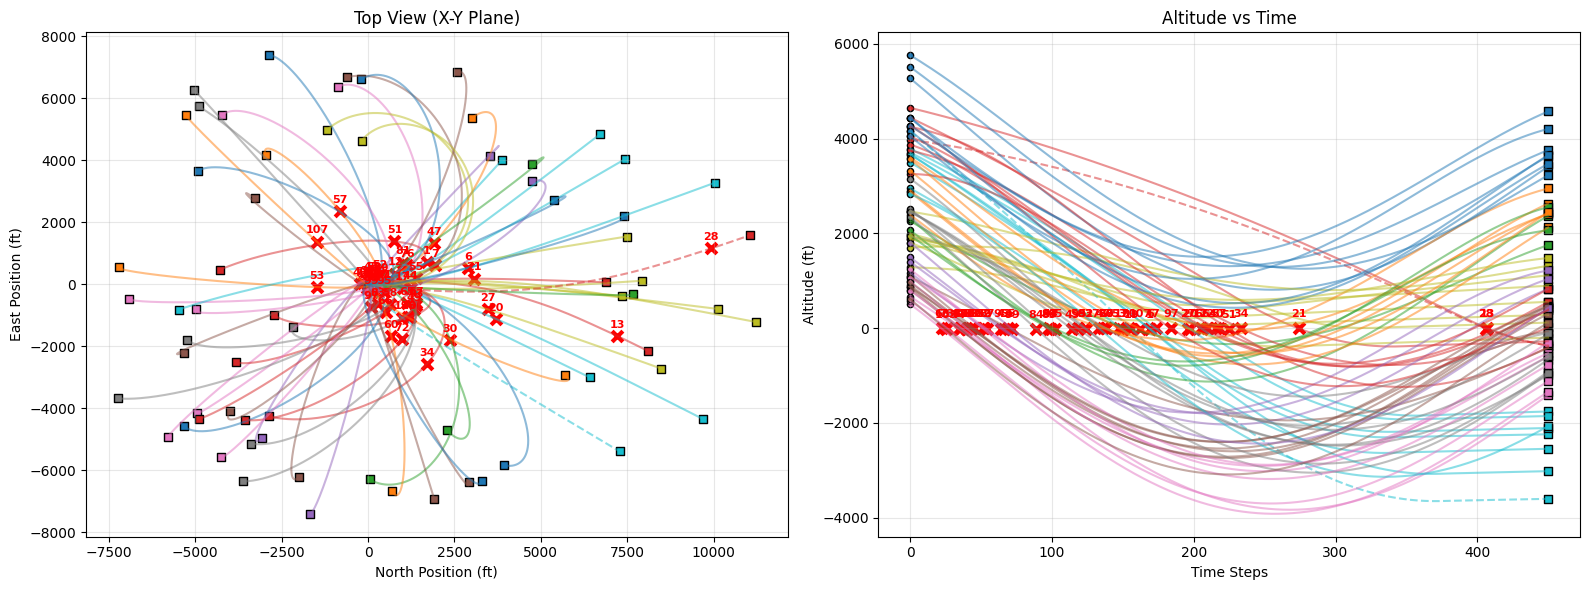

In [8]:
# 2D plotting - x-y plane and altitude vs time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# x-y plane
ax1 = axes[0]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    if result.crashed:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]

        ax1.scatter(
            crash_x,
            crash_y,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax1.text(
            crash_x,
            crash_y + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

    ax1.scatter(
        traj[0, 0],
        traj[0, 1],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax1.scatter(
        traj[-1, 0],
        traj[-1, 1],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax1.set_xlabel("North Position (ft)")
ax1.set_ylabel("East Position (ft)")
ax1.set_title("Top View (X-Y Plane)")
ax1.grid(True, alpha=0.3)

# altitude vs time
ax2 = axes[1]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]

    time_steps = np.arange(len(traj))

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    if result.crashed:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_time = time_steps[crash_idx]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_time = time_steps[min_alt_idx]
            crash_z = traj[min_alt_idx, 2]

        ax2.scatter(
            crash_time,
            crash_z,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax2.text(
            crash_time,
            crash_z + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

    ax2.scatter(
        0,
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax2.scatter(
        len(traj) - 1,
        traj[-1, 2],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Altitude (ft)")
ax2.set_title("Altitude vs Time")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_2d.png")
    print(f"2D plots saved to results/{seed}_clusters_2d.png")

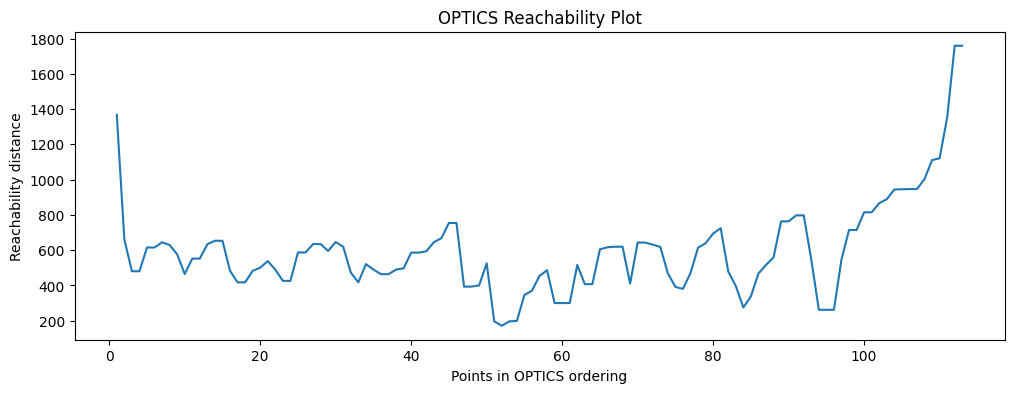

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(reachability[ordering])
plt.xlabel("Points in OPTICS ordering")
plt.ylabel("Reachability distance")
plt.title("OPTICS Reachability Plot")
plt.show()